<a href="https://colab.research.google.com/github/33quitykubby/Rabbit/blob/main/Rabbit_ML_3_PCA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 主成分分析モデル

scikit-learnによる主成分分析(写経）

最初にLogisitic回帰で確認した後、PCAで二次元化して図示
  
1.  model定義    
2.  fit  
3. predict  

TODO
numpy実装→np_pca.ipynbベースで図示まで


# マウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 日本時間にする

In [2]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

Sat Apr 10 13:07:32 JST 2021


# ライブラリのインポート

In [3]:
import pandas as pd
import numpy as np
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import  confusion_matrix
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns

#これでplt.show()しなくてよい
%matplotlib inline

import os
import glob

import librosa

import datetime

import gc

In [4]:
#開始時刻
start_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("start_time=",start_time)

start_time= 2021-04-10 13:07:35.593176+09:00


# 乱数シードの初期化






In [5]:
import os 
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

COMMON_SEED = 0
STANDARD_SEED = 0
NP_SEED = 0
TF_SEED = 0 

# np.random.seed(STANDARD_SEED)
# random.seed(NP_SEED)
# tf.random.set_seed(TF_SEED)

def seed_everything():
    random.seed(STANDARD_SEED)
    os.environ['PYTHONHASHSEED'] = str(COMMON_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    np.random.seed(NP_SEED)
    tf.random.set_seed(TF_SEED)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


In [6]:
#乱数シード固定

seed_everything()

# パス定義

In [7]:
DATA_PATH = '/content/drive/MyDrive/RabbitChallenge/study_ai_ml_google/data/'

# データ読み込み

In [8]:
cancer_df = pd.read_csv(DATA_PATH+'cancer.csv')

print("shape=",cancer_df.shape)

cancer_df

shape= (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


## 不要データの削除

In [9]:
cancer_df.drop(['Unnamed: 32'],axis=1,inplace=True)

cancer_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# ロジスティック回帰

まずdiagnosis（良性：B, 悪性：M）をロジスティック回帰でどの程度分類できるか確認

In [10]:
# 目的変数の抽出

y = cancer_df.diagnosis.apply(lambda d: 1 if d == 'M' else 0 )

# 説明変数の抽出(radius_mean以降全部)

X = cancer_df.loc[:, 'radius_mean':]

print(X.shape)

X

(569, 30)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [11]:
# 学習用とテスト用でデータを分離

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#ロジスティク回帰で学習
logistic = LogisticRegressionCV(cv=10, random_state=0)
logistic.fit(X_train_scaled, y_train)

#検証
print("Train score: {:.3f}".format(logistic.score(X_train_scaled, y_train)))
print("Test score:  {:.3f}".format(logistic.score(X_test_scaled, y_test)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_true=y_test,y_pred=logistic.predict(X_test_scaled))))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train score: 0.988
Test score:  0.972
Confusion matrix:
[[89  1]
 [ 3 50]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# PCAで解析

## scikitlearn

<BarContainer object of 30 artists>

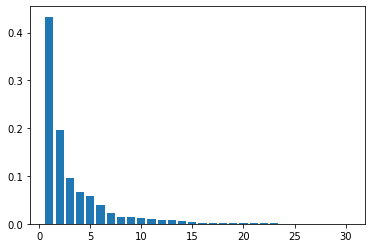

In [12]:
pca = PCA(n_components=30)
pca.fit(X_train_scaled)
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)],pca.explained_variance_ratio_)

In [13]:
# PCA
# 第二主成分までで主成分分析

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

print('X_train_pca shape:',X_train_pca.shape)
print("explained variance ratio:",pca.explained_variance_ratio_)

X_train_pca shape: (426, 2)
explained variance ratio: [0.43315126 0.19586506]


Text(0, 0.5, 'PC 2')

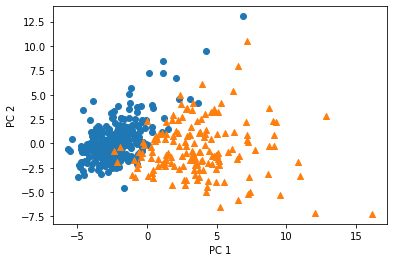

In [14]:
#散布図にプロット
temp = pd.DataFrame(X_train_pca)
temp['Outcome'] = y_train.values

b = temp[temp['Outcome'] == 0]
m = temp[temp['Outcome'] == 1]

plt.scatter(x=b[0], y=b[1], marker='o') #良性は〇
plt.scatter(x=m[0], y=m[1], marker='^') #悪性は△
plt.xlabel('PC 1') #第一主成分をx軸
plt.ylabel('PC 2') #第二主成分をy軸



## numpy

In [64]:
n_components=2

def get_moments(X):
    # Xの平均
    mean = X.mean(axis=0)
    # Xの分散 
    stan_cov = np.dot((X - mean).T, X - mean) / (len(X) - 1)
    
    return mean, stan_cov
    
def get_components(eigenvectors, n_components):
    W = eigenvectors[:, ::-1][:, :n_components]
    return W.T

def plt_result(X, first, second):
    plt.scatter(X[:, 0], X[:, 5])
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    # 第１主成分
    plt.quiver(0, 0, first[0], first[1], width=0.01, scale=6, color='red')
    # 第２主成分
    plt.quiver(0, 0, second[0], second[1], width=0.01, scale=6, color='green')

In [56]:
##分散共分散行列を標準化
mean_X, stan_cov = get_moments(X_train_scaled)

print("X_train.shape",X_temp.shape)
print("stan_cov.shape",stan_cov.shape)

X_train.shape (426, 30)
stan_cov.shape (30, 30)


In [57]:
#固有値と固有ベクトルを計算
eigenvalues, eigenvectors = np.linalg.eigh(stan_cov)

print("eigenvalues=",eigenvalues)
# print("eigenvectors=",eigenvectors)

eigenvalues= [1.10439880e-04 7.71745973e-04 1.41240170e-03 6.51424781e-03
 7.82766598e-03 1.64569947e-02 1.80792225e-02 2.16897495e-02
 2.56848104e-02 3.16091845e-02 3.18607690e-02 4.50058627e-02
 5.06843953e-02 5.98234234e-02 7.97005702e-02 9.42179632e-02
 1.50829501e-01 2.36184002e-01 2.68491949e-01 3.14136678e-01
 3.53769922e-01 4.24150528e-01 4.48046127e-01 6.54512035e-01
 1.20937017e+00 1.71733052e+00 2.00948748e+00 2.87793898e+00
 5.88977769e+00 1.30251132e+01]


In [58]:
components = get_components(eigenvectors, n_components)

print("components=",components)

components= [[-0.22136524 -0.10000219 -0.22951811 -0.22352098 -0.14302288 -0.24211071
  -0.26026925 -0.26425272 -0.1342154  -0.058505   -0.20686479 -0.00729622
  -0.20987422 -0.20223841 -0.01725187 -0.16639025 -0.13855921 -0.17994092
  -0.02943904 -0.10192967 -0.23041956 -0.100572   -0.23779661 -0.22751009
  -0.13135979 -0.21077884 -0.2301419  -0.25334406 -0.11911651 -0.13088259]
 [ 0.2301732   0.05721755  0.21335503  0.22693534 -0.17877041 -0.14744861
  -0.06557463  0.03134067 -0.19050711 -0.36396122  0.10501365 -0.0939736
   0.0974744   0.14961032 -0.21204003 -0.235435   -0.21050921 -0.15228014
  -0.1810749  -0.27867942  0.2159829   0.04249497  0.20003599  0.21518192
  -0.17146856 -0.13883173 -0.10503362 -0.00064033 -0.14065767 -0.27318654]
 [-0.00509147  0.02952191 -0.00535985  0.03648728 -0.09760612 -0.07562818
   0.0225777  -0.01697712 -0.03700781 -0.02546731  0.28030893  0.34876487
   0.27421016  0.2326853   0.29456412  0.15997911  0.19133204  0.21203293
   0.28801172  0.21203469

(426, 30)


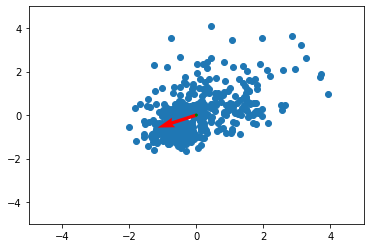

In [65]:
# print(eigenvectors[0, :])
# print(eigenvectors[1, :])

print(X_train_scaled.shape)

plt_result(X_train_scaled, eigenvectors[0, :], eigenvectors[1, :])

# 終わり

In [60]:
#終了時刻
finish_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",finish_time)
print("total_time=",finish_time-start_time)


finish_time= 2021-04-10 13:44:22.223352+09:00
total_time= 0:36:46.630176
